# Kinect 2D to 3D

In [1]:
import numpy as np
import tensorflow as tf

random_state = 47
np.random.seed(random_state)

# MLflow dashboard
import mlflow
mlflow.set_tracking_uri('http://35.228.45.76:5000')
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='../../keys/mlflow-312506-8cfad529f4fd.json'

import warnings
warnings.simplefilter('ignore')

In [2]:
physical_devices = tf.config.experimental.list_physical_devices( 'GPU' )
print( 'Num GPUs Available: ', len( physical_devices ) )
if len( physical_devices ) > 0:
    tf.config.experimental.set_memory_growth( physical_devices[0], True )

Num GPUs Available:  1


# 1. Data Preparation

## 1.1 Load the Data

We're selecting 10 random sequences and joining them into a dataset which we then split into a train set and a test set. <br />
To get repeatable results, we're using a random seed.

The **read_from_file** method splits each CSV file so that the Z columns (third dimension) are used as targets and the rest (X,Y columns) are used as predictors.

In [3]:
import re

def read_from_file( file_name ):
    data = pd.read_csv('https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/kinect_good_preprocessed/{}.csv'.format( file_name ))
    data = data.drop( columns=['FrameNo'] )

    target_labels = []
    for c in data.columns:
        if re.search("^.*_z$", c):
            target_labels.append(c)

    target_data = data[target_labels]
    input_data = data.drop( columns=target_labels )
    
    return input_data, target_data

In [4]:
import random
import pandas as pd
from sklearn.utils import shuffle

# Generate 10 random numbers
X, y = read_from_file('A1_kinect')
files = random.sample(range(2, 151), 10)

# Retrieve 10 training sequences
for i in files:
    try:
        iData, tData = read_from_file('A{}_kinect'.format(i))
        X = np.concatenate((X, iData))
        y = np.concatenate((y, tData))
    except IOError as e:
        print('Error in reading A{}_kinect.csv'.format(i),e)

X, y = shuffle(X, y)

## 1.2 Train/val/test Split

We're splitting the dataset into three sets for:

- Training,
- Validation, and 
- Testing. 

The training and validation sets are used during training, and the test set acts like the holdout set which we use to evaluate the model performance after the fitting. It has a size of 0.1 (10%).

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [6]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)

X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_val = y_scaler.transform(y_val)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (1104, 26)
Training labels shape: (1104, 13) 

Validation features shape: (277, 26)
Validation labels shape: (277, 13) 

Test features shape: (154, 26)
Test labels shape: (154, 13) 



Now, the data preparation is finished and we can start experimenting with DL models.

# 2. Define and Train the Models

We decided to perform a Grid search parameter optimization on a Dense model, and after those configurations are chosen based on the best result, we compare that Dense model to another model architecture using convolutional layers.

The grid search parameter optimization includes:

- Batch size;

- Learning rate;

- Number of neurons in the hidden layers;

- Different activation functions; and 

- Various state-of-the-art optimization algorithms for compiling the model.

We're creating our models with Keras Sequential class.

Finally, if we want to use grid search to check these configurations, we need to use our Keras model with scikit-learn by wrapping it with the KerasRegressor class.

So, below, we declare the early stopping callback which we will (hopefully) use to prevent overfitting when training the models. Here, we would like to look at the MSE and if it hasn't decreased in 10 epochs, we'll stop the training early.<br /> 
We also set parameter values for the grid search optimization.

## 2.1 Prepare for Grid Search 

In [7]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_mse', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

EPOCHS = 50
BATCH_SIZE = [16, 32, 68, 150]

learning_rate = [0.0001, 0.001, 0.01]
LOSS = 'mse' # Using MSE as loss
activation = ['relu', 'tanh', 'sigmoid', 'linear']
optimizer = ['SGD', 'RMSprop', 'Adam']
output_layer = ['', 'linear', 'sigmoid']
neurons = [13, 26, 39, 52, 64]

METRICS = [
    tf.keras.metrics.MeanSquaredError(name="mse", dtype=None),
    tf.keras.metrics.MeanAbsoluteError(name="mae", dtype=None),
    tf.keras.metrics.RootMeanSquaredError(name="rmse", dtype=None),
]

# Grid search parameters
#param_grid = dict(activation=activation, output_layer=output_layer, batch_size=BATCH_SIZE, optimizer=optimizer, learning_rate=learning_rate, neurons=neurons)

## 2.2 Define a Sequential model with 2 Dense (fully-connected) layers

Then, we define the Dense model architecture. We'll be using a make_model function which receives the grid search parameters values and goes through the optimization for this type of model.

In [8]:
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, InputLayer

#def make_model(optimizer='RMSprop', neurons=64, learning_rate=0.0001, activation=activation, output_layer=output_layer):
  #model = Sequential([
    #InputLayer(input_shape=(X_train.shape[1]))
  #])
  #model.add(Dense( units=neurons, activation=activation ))
  #model.add(Dense( units=neurons, activation=activation ))
  #if not output_layer:
    #model.add(Dense( units=13 ))
  #else:
    #model.add(Dense( units=13, activation=output_layer ))

  #optimizer = tf.keras.optimizers.get(optimizer)
  #optimizer.learning_rate.assign(learning_rate)

  #model.compile( optimizer=optimizer, loss=LOSS, metrics=METRICS )

  #return model

#model = KerasRegressor(build_fn=make_model, verbose=2)

Now we're ready to perform Grid search optimization with cross-validation and it tries all the combinations of the values passed in the param_grid dictionary.

We don't use early stopping in this situation as we don't want to intermingle early stopping with the cross validation procedure because that seems counterintuitive when we're trying to find the best parameter values and we don't want to stop before going through all rounds. However, early stopping will be used later when fitting the models.

When running GridSearchCV, it takes a very long time and therefore, we only run a 3 fold cross-validation, resulting in fitting 3 folds for each of 2160 candidates, totalling 6480 fits!

In [9]:
#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)
#grid_result = grid.fit(X, y)

#print("\nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
    #print("%f (%f) with: %r" % (mean, stdev, param))

## 2.3 Define an MLflow Experimentation

The Model signature in MLflow defines the schema of a model's inputs and outputs.

In [10]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

input_schema = Schema([
    ColSpec("double", "head_x"),
    ColSpec("double", "head_y"),
    ColSpec("double", "left_shoulder_x"),
    ColSpec("double", "left_shoulder_y"),
    ColSpec("double", "left_elbow_x"),
    ColSpec("double", "left_elbow_y"),
    ColSpec("double", "right_shoulder_x"),
    ColSpec("double", "right_shoulder_y"),
    ColSpec("double", "right_elbow_x"),
    ColSpec("double", "right_elbow_y"),
    ColSpec("double", "left_hand_x"),
    ColSpec("double", "left_hand_y"),
    ColSpec("double", "right_hand_x"),
    ColSpec("double", "right_hand_y"),
    ColSpec("double", "left_hip_x"),
    ColSpec("double", "left_hip_y"),
    ColSpec("double", "right_hip_x"),
    ColSpec("double", "right_hip_y"),
    ColSpec("double", "left_knee_x"),
    ColSpec("double", "left_knee_y"),
    ColSpec("double", "right_knee_x"),
    ColSpec("double", "right_knee_y"),
    ColSpec("double", "left_foot_x"),
    ColSpec("double", "left_foot_y"),
    ColSpec("double", "right_foot_x"),
    ColSpec("double", "right_foot_y"),
])
output_schema = Schema([
    ColSpec("double", "head_x"),
    ColSpec("double", "head_y"),
    ColSpec("double", "head_z"),
    ColSpec("double", "left_shoulder_x"),
    ColSpec("double", "left_shoulder_y"),
    ColSpec("double", "left_shoulder_z"),
    ColSpec("double", "left_elbow_x"),
    ColSpec("double", "left_elbow_y"),
    ColSpec("double", "left_elbow_z"),
    ColSpec("double", "right_shoulder_x"),
    ColSpec("double", "right_shoulder_y"),
    ColSpec("double", "right_shoulder_z"),
    ColSpec("double", "right_elbow_x"),
    ColSpec("double", "right_elbow_y"),
    ColSpec("double", "right_elbow_z"),
    ColSpec("double", "left_hand_x"),
    ColSpec("double", "left_hand_y"),
    ColSpec("double", "left_hand_z"),
    ColSpec("double", "right_hand_x"),
    ColSpec("double", "right_hand_y"),
    ColSpec("double", "right_hand_z"),
    ColSpec("double", "left_hip_x"),
    ColSpec("double", "left_hip_y"),
    ColSpec("double", "left_hip_z"),
    ColSpec("double", "right_hip_x"),
    ColSpec("double", "right_hip_y"),
    ColSpec("double", "right_hip_z"),
    ColSpec("double", "left_knee_x"),
    ColSpec("double", "left_knee_y"),
    ColSpec("double", "left_knee_z"),
    ColSpec("double", "right_knee_x"),
    ColSpec("double", "right_knee_y"),
    ColSpec("double", "right_knee_z"),
    ColSpec("double", "left_foot_x"),
    ColSpec("double", "left_foot_y"),
    ColSpec("double", "left_foot_z"),
    ColSpec("double", "right_foot_x"),
    ColSpec("double", "right_foot_y"),
    ColSpec("double", "right_foot_z"),
])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

## 2.4 Functions for creating plots

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (15, 12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [12]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

def plot_training_history(history):
  metrics = ['loss', 'mae', 'mse', 'rmse']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

def eval_metrics(actual, pred):
    mse = mean_squared_error(actual, pred)
    msa = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    variance = explained_variance_score(actual, pred)
    return mse, msa, r2, variance

## 2.5 Train the Dense Model

At this stage, we want to create, compile, and train a Dense DL Model with the best parameter values that we received from the Grid search. First, let'ts take a look at what the best parameter values actually turned out to be.

In [13]:
grid_result_best_params_ = {'activation': 'relu',
    'batch_size': 16,
    'learning_rate': 0.01,
    'neurons': 39,
    'optimizer': 'Adam',
    'output_layer': 'linear'
}

grid_result_best_params_

{'activation': 'relu',
 'batch_size': 16,
 'learning_rate': 0.01,
 'neurons': 39,
 'optimizer': 'Adam',
 'output_layer': 'linear'}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 39)                1053      
_________________________________________________________________
dense_1 (Dense)              (None, 39)                1560      
_________________________________________________________________
dense_2 (Dense)              (None, 13)                520       
Total params: 3,133
Trainable params: 3,133
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
69/69 [==============================] - 1s 6ms/step - loss: 0.2497 - mse: 0.2497 - mae: 0.3714 - rmse: 0.4997 - val_loss: 0.0973 - val_mse: 0.0973 - val_mae: 0.2397 - val_rmse: 0.3119
Epoch 2/500
69/69 [==============================] - 0s 4ms/step - loss: 0.0580 - mse: 0.0580 - mae: 0.1857 - rmse: 0.2408 - val_loss: 0.0416 - val_mse: 0.0416 - val_mae: 0.1594 - val_rms

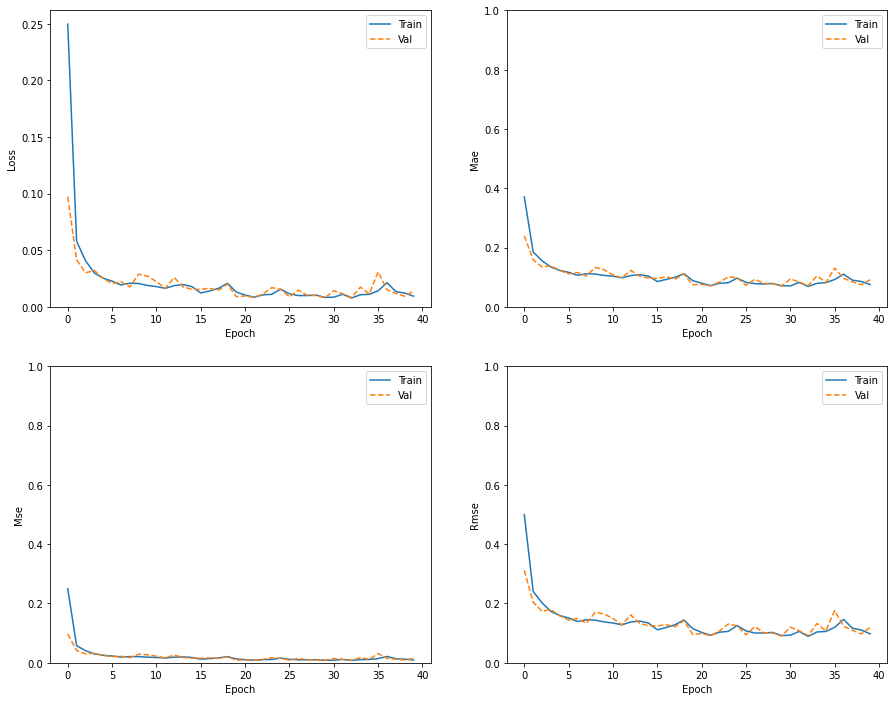

MSE:  7.805599104862508e-05
mae:  0.006689022932805868
R-Squared:  0.991393793573713
Explained Variance Score:  0.9917856999447456
INFO:tensorflow:Assets written to: C:\Users\angel\AppData\Local\Temp\tmpjuwu1dcz\model\data\model\assets


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense

model_name = 'kinect2d_to_3d_densemodel'

with mlflow.start_run(run_name=model_name) as run:

    run_id = run.info.run_id

    dense_model = Sequential([
        InputLayer(input_shape=(X_train.shape[1]))
    ])
    dense_model.add(Dense( units=grid_result_best_params_['neurons'], activation=grid_result_best_params_['activation'] ))
    dense_model.add(Dense( units=grid_result_best_params_['neurons'], activation=grid_result_best_params_['activation'] ))
    if not grid_result_best_params_['output_layer']:
        dense_model.add(Dense( units=13 )) # There's no activation function in the output layer
    else: 
        dense_model.add(Dense( units=13, activation=grid_result_best_params_['output_layer'] ))

    optimizer = tf.keras.optimizers.get(grid_result_best_params_['optimizer'])
    optimizer.learning_rate.assign(grid_result_best_params_['learning_rate'])

    dense_model.compile( optimizer=optimizer, loss=LOSS, metrics=METRICS )

    dense_model.summary()
    
    dense_model_history = dense_model.fit(
        x=X_train, 
        y=y_train, 
        validation_data=(X_val, y_val), 
        shuffle=True, 
        epochs=500, 
        verbose=1,
        batch_size=grid_result_best_params_['batch_size'], 
        callbacks=[early_stopping])

    # Plot training history
    plot_training_history(dense_model_history)
    plt.savefig("training_history.jpg")
    mlflow.log_artifact("training_history.jpg")
    plt.show()
        
    # Look at the model performance
    dense_model_predictions = dense_model.predict(X_test)
    # Invert transform on predictions
    dense_model_predictions = y_scaler.inverse_transform(dense_model_predictions)
        
    (mse, mae, r2, variance) = eval_metrics(y_test, dense_model_predictions)
    print('MSE: ', mse)
    print('mae: ', mae)
    print('R-Squared: ', r2)
    print('Explained Variance Score: ', variance)
        
    # Log model parameters and metrics
    mlflow.log_param("units", grid_result_best_params_['neurons'])
    mlflow.log_param("activation", grid_result_best_params_['activation'])
    mlflow.log_param("output activation", grid_result_best_params_['output_layer'])
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("learning rate", grid_result_best_params_['learning_rate'])
    mlflow.log_param("batch size", grid_result_best_params_['batch_size'])
    mlflow.log_param("epochs", early_stopping.stopped_epoch)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("R-squared", r2)
    mlflow.log_metric("variance", variance)

    # Log model and scaler(s)
    mlflow.keras.log_model(dense_model, model_name, signature=signature)
    mlflow.sklearn.log_model(X_scaler, 'InputScaler')
    mlflow.sklearn.log_model(y_scaler, 'OutputScaler')

Let's register the model

In [16]:
model_uri = "runs:/{}/{}".format(run.info.run_id, model_name)
mv = mlflow.register_model(model_uri, model_name)
print("Name: {}".format(mv.name))
print("Version: {}".format(mv.version))

Successfully registered model 'kinect2d_to_3d_densemodel'.
2021/05/20 23:52:26 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: kinect2d_to_3d_densemodel, version 1
Name: kinect2d_to_3d_densemodel
Version: 1
Created version '1' of model 'kinect2d_to_3d_densemodel'.


## 2.6 Sequential model with Convolutional Layer

We want to compare the performance of the Dense model with another layer structure. Instead of using two hidden dense layers, this model will use a 1D convolution layer followed by a layer to flatten the input, and a dense layer for the output.

First, we must reshape the input data for the convolutional layer by adding one dimension.

In [17]:
from numpy import unique
orig_shape = X_train.shape[1:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

in_shape = X_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))

Before: (26,)
After: (26, 1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 14, 39)            546       
_________________________________________________________________
flatten (Flatten)            (None, 546)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 13)                7111      
Total params: 7,657
Trainable params: 7,657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
69/69 [==============================] - 13s 5ms/step - loss: 0.1910 - mse: 0.1556 - mae: 0.2820 - rmse: 0.3944 - val_loss: 0.0932 - val_mse: 0.0932 - val_mae: 0.2397 - val_rmse: 0.3053
Epoch 2/150
69/69 [==============================] - 0s 4ms/step - loss: 0.0724 - mse: 0.0724 - mae: 0.2098 - rmse: 0.2690 - val_loss: 0.0455 - val_mse: 0.0455 - val_mae: 0.1686 - val_

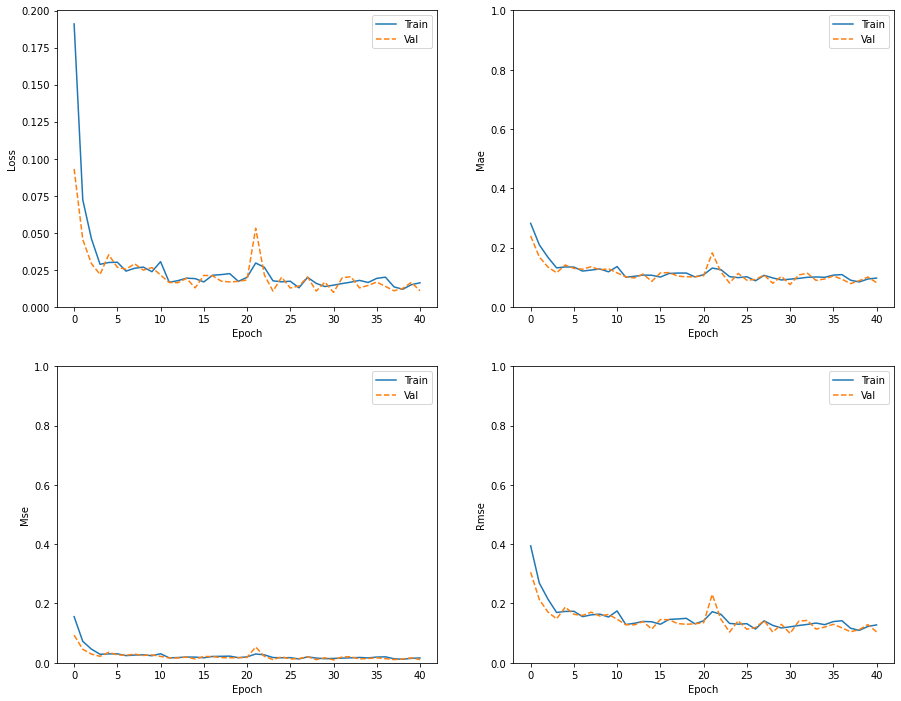

MSE:  9.810452117536954e-05
mae:  0.0073012780222263315
R-Squared:  0.9897176209892523
Explained Variance Score:  0.9901349606509579
INFO:tensorflow:Assets written to: C:\Users\angel\AppData\Local\Temp\tmpwcjgm7_o\model\data\model\assets


In [19]:
from tensorflow.keras.layers import Input, Conv1D, Flatten

model_name = 'kinect2d_to_3d_cnn'

with mlflow.start_run(run_name=model_name) as run:

    run_id = run.info.run_id

    model_cnn = Sequential([
        Input( shape=( time_steps, input_dimension ) ),
        Conv1D( filters=grid_result_best_params_['neurons'] , kernel_size=13, activation=grid_result_best_params_['activation'] ),
        Flatten(),
        Dense( units=13 )
    ])

    optimizer = tf.keras.optimizers.get(grid_result_best_params_['optimizer'])
    optimizer.learning_rate.assign(grid_result_best_params_['learning_rate'])

    model_cnn.compile( optimizer=optimizer, loss=LOSS, metrics=METRICS )

    model_cnn.summary()
    
    model_cnn_history = model_cnn.fit(
        x=X_train, 
        y=y_train, 
        validation_data=(X_val, y_val), 
        shuffle=True, 
        epochs=150, 
        verbose=1,
        batch_size=grid_result_best_params_['batch_size'], 
        callbacks=[early_stopping])

    # Plot training history
    plot_training_history(model_cnn_history)
    plt.savefig("training_history.jpg")
    mlflow.log_artifact("training_history.jpg")
    plt.show()
        
    # Look at the model performance
    model_cnn_predictions = model_cnn.predict(X_test)
    # Invert transform on predictions
    model_cnn_predictions = y_scaler.inverse_transform(model_cnn_predictions)
        
    (mse, mae, r2, variance) = eval_metrics(y_test, model_cnn_predictions)
    print('MSE: ', mse)
    print('mae: ', mae)
    print('R-Squared: ', r2)
    print('Explained Variance Score: ', variance)
        
    # Log model parameters and metrics
    mlflow.log_param("units", grid_result_best_params_['neurons'])
    mlflow.log_param("activation", grid_result_best_params_['activation'])
    mlflow.log_param("output activation", grid_result_best_params_['output_layer'])
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("learning rate", grid_result_best_params_['learning_rate'])
    mlflow.log_param("batch size", grid_result_best_params_['batch_size'])
    mlflow.log_param("epochs", early_stopping.stopped_epoch)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("R-squared", r2)
    mlflow.log_metric("variance", variance)

    # Log model and scaler(s)
    mlflow.keras.log_model(model_cnn, model_name, signature=signature)
    mlflow.sklearn.log_model(X_scaler, 'InputScaler')
    mlflow.sklearn.log_model(y_scaler, 'OutputScaler')